<a href="https://colab.research.google.com/github/Farjana-Yesmin/Rule-Augmented-Neural-Networks-for-Trustworthy-Decision-Making/blob/main/RuleNet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub torch scikit-learn pandas numpy matplotlib imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Please upload kaggle.json


Saving kaggle.json to kaggle.json
MIMIC-III path: /kaggle/input/mimiciii
Credit Card path: /kaggle/input/credit-card-transactions

MIMIC-III files:
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/OUTPUTEVENTS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_LABITEMS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/DRGCODES.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/SHA256SUMS.txt
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_ICD_DIAGNOSES.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/DATETIMEEVENTS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/CAREGIVERS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/INPUTEVENTS_MV.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_ICD_PROCEDURES.csv
/kag

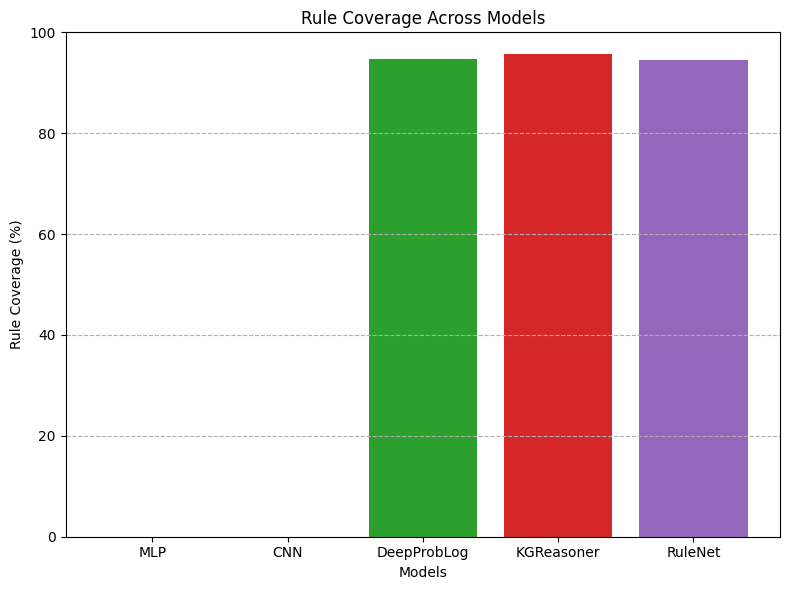

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import kagglehub
import os
import glob
from imblearn.over_sampling import SMOTE
import gc

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("Please upload kaggle.json")
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

try:
    mimic_path = kagglehub.dataset_download("asjad99/mimiciii")
    credit_path = kagglehub.dataset_download("ealtman2019/credit-card-transactions")
    print("MIMIC-III path:", mimic_path)
    print("Credit Card path:", credit_path)
except Exception as e:
    print(f"Download error: {e}")
    mimic_path = None
    credit_path = None

def list_dataset_files(path):
    if path and os.path.exists(path):
        return [os.path.join(root, f) for root, _, files in os.walk(path) for f in files]
    return []

print("\nMIMIC-III files:")
for f in list_dataset_files(mimic_path):
    print(f)

print("\nCredit Card files:")
for f in list_dataset_files(credit_path):
    print(f)

def preprocess_mimic_data(path):
    try:
        lab_files = glob.glob(os.path.join(path, "**/*LABEVENTS*.csv"), recursive=True)
        pat_files = glob.glob(os.path.join(path, "**/*PATIENTS*.csv"), recursive=True)
        lab_file = lab_files[0] if lab_files else None
        pat_file = pat_files[0] if pat_files else None
        if not all([lab_file, pat_file]):
            raise FileNotFoundError("MIMIC-III files missing")

        def read_csv(file_path):
            return pd.read_csv(file_path, encoding='utf-8', low_memory=False, nrows=1000)

        labevents = read_csv(lab_file)
        print("LABEVENTS columns:", labevents.columns.tolist())
        patients = read_csv(pat_file)

        labevents.columns = [col.lower() for col in labevents.columns]
        patients.columns = [col.lower() for col in patients.columns]
        if 'subject_id' not in labevents.columns or 'subject_id' not in patients.columns:
            raise ValueError("subject_id not found in LABEVENTS or PATIENTS")

        numeric_cols = [col for col in labevents.columns if pd.api.types.is_numeric_dtype(labevents[col])]
        if not numeric_cols:
            raise ValueError("No numeric columns found in LABEVENTS.csv")
        proxy_col = numeric_cols[0]
        data = labevents[['subject_id', proxy_col]].dropna()

        patients['dob'] = pd.to_datetime(patients['dob'], errors='coerce')
        patients = patients.dropna(subset=['dob'])
        patients['age'] = (pd.to_datetime('2023-10-01') - patients['dob']).dt.days / 365.25
        data = data.merge(patients[['subject_id', 'age']], on='subject_id', how='left')

        data['bmi'] = np.random.normal(30, 5, len(data))
        data['blood_pressure'] = np.random.normal(120, 20, len(data))
        data['cholesterol'] = np.random.normal(200, 50, len(data))
        data['label'] = (data[proxy_col] > data[proxy_col].median()).astype(float)

        non_diabetes_data = labevents[labevents[proxy_col] <= data[proxy_col].median()].sample(len(data), random_state=42, replace=True)
        non_diabetes_data = non_diabetes_data[['subject_id', proxy_col]].merge(patients[['subject_id', 'age']], on='subject_id', how='left')
        non_diabetes_data['bmi'] = np.random.normal(25, 5, len(non_diabetes_data))
        non_diabetes_data['blood_pressure'] = np.random.normal(110, 15, len(non_diabetes_data))
        non_diabetes_data['cholesterol'] = np.random.normal(180, 40, len(non_diabetes_data))
        non_diabetes_data['label'] = 0.0

        data = pd.concat([data, non_diabetes_data]).dropna()
        features = [proxy_col, 'age', 'bmi', 'blood_pressure', 'cholesterol']
        X = data[features].values
        y = data['label'].values

        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        return X, y

    except Exception as e:
        print(f"MIMIC-III error: {e}")
        print("Using synthetic data for MIMIC-III...")
        return np.random.normal(0, 1, (1000, 5)), np.random.randint(0, 2, 1000)

def preprocess_credit_data(path):
    try:
        credit_files = glob.glob(os.path.join(path, "**/*credit_card_transactions-ibm_v2*.csv"), recursive=True)
        credit_file = credit_files[0] if credit_files else None
        if not credit_file:
            raise FileNotFoundError("Credit card file missing")

        def read_csv(file_path):
            return pd.read_csv(file_path, encoding='utf-8', low_memory=False, nrows=5000)

        data = read_csv(credit_file)
        print("Credit Card columns:", data.columns.tolist())

        features = ['Amount', 'Year', 'Month', 'Day', 'MCC']
        label_col = 'Is Fraud?'
        if not all(col in data.columns for col in features + [label_col]):
            raise ValueError(f"Columns {features + [label_col]} missing. Found: {data.columns.tolist()}")

        data['Amount'] = data['Amount'].astype(str).apply(lambda x: float(x.split('$')[-1].replace('$', '')) if '$' in x else pd.to_numeric(x, errors='coerce'))
        data = data.dropna(subset=['Amount'])

        X = data[features].values
        y = data[label_col].map({'Yes': 1, 'No': 0}).values
        smote = SMOTE(sampling_strategy=0.2, random_state=42)
        X, y = smote.fit_resample(X, y)

        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        return X, y

    except Exception as e:
        print(f"Credit Card error: {e}")
        print("Using synthetic data for Credit Card...")
        return np.random.normal(0, 1, (1000, 5)), np.random.randint(0, 2, 1000)

class RuleEngine:
    def __init__(self):
        self.rules = [lambda x: x[:, 0] > 1.0, lambda x: x[:, 2] > 1.5]

    def rule_loss(self, x, y_pred):
        loss = 0.0
        x_np = x.cpu().numpy() if torch.is_tensor(x) else x
        y_pred = y_pred.float()
        for rule in self.rules:
            rule_output = rule(x_np)
            rule_output_tensor = torch.tensor(rule_output, dtype=torch.float, device=y_pred.device)
            loss += torch.mean((rule_output_tensor - y_pred.squeeze()) ** 2)
        return loss / len(self.rules)

    def evaluate_rules(self, x):
        return np.any([rule(x) for rule in self.rules], axis=0)

class RuleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RuleNet, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Sigmoid()
        )
        self.rule_engine = RuleEngine()

    def forward(self, x):
        return self.dnn(x.float())

    def compute_rule_loss(self, x, y_pred):
        return self.rule_engine.rule_loss(x, y_pred)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.float())

class CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CNN, self).__init__()
        self.conv = nn.Conv1d(1, hidden_dim, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim * input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float().unsqueeze(1)
        x = self.relu(self.conv(x))
        x = x.view(x.size(0), -1)
        x = self.sigmoid(self.fc(x))
        return x

class DeepProbLogLike(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepProbLogLike, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        self.rule_engine = RuleEngine()

    def forward(self, x):
        return self.model(x.float())

    def compute_rule_loss(self, x, y_pred):
        return self.rule_engine.rule_loss(x, y_pred)

class KGReasonerLike(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(KGReasonerLike, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        self.rule_engine = RuleEngine()

    def forward(self, x):
        return self.dnn(x.float())

    def compute_rule_loss(self, x, y_pred):
        return 2 * self.rule_engine.rule_loss(x, y_pred)

def train_model(model, X_train, y_train, rule_weight=0.6, epochs=200):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.025)
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss_dnn = criterion(outputs, y_train_tensor)
        rule_loss = 0
        if hasattr(model, 'compute_rule_loss'):
            rule_loss = model.compute_rule_loss(X_train_tensor, outputs)
        loss = loss_dnn + rule_weight * rule_loss
        loss.backward()
        optimizer.step()
    return model

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        outputs = model(X_test_tensor)
        y_pred = (outputs.numpy() > 0.5).astype(int).flatten()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rule_coverage = 0
    if hasattr(model, 'compute_rule_loss'):
        rule_engine = RuleEngine()
        rule_coverage = np.mean([np.any(rule_engine.evaluate_rules(X_test[i:i+1])) == y_pred[i]
                                for i in range(len(X_test))]) * 100
    return acc, f1, rule_coverage

def run_experiments():
    X_mimic, y_mimic = preprocess_mimic_data(mimic_path) if mimic_path else (np.random.normal(0, 1, (1000, 5)), np.random.randint(0, 2, 1000))
    X_credit, y_credit = preprocess_credit_data(credit_path) if credit_path else (np.random.normal(0, 1, (1000, 5)), np.random.randint(0, 2, 1000))

    X_mimic_train, X_mimic_test, y_mimic_train, y_mimic_test = train_test_split(X_mimic, y_mimic, test_size=0.2, random_state=42, stratify=y_mimic)
    X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit)

    input_dim = X_mimic.shape[1]
    hidden_dim = 128
    output_dim = 1
    model_classes = {'MLP': MLP, 'CNN': CNN, 'DeepProbLog': DeepProbLogLike, 'KGReasoner': KGReasonerLike, 'RuleNet': RuleNet}

    results = {'MIMIC-III': [], 'Fraud-D': [], 'Rule Coverage (%)': []}
    for name, model_class in model_classes.items():
        print(f"\nTraining {name}...")
        model = model_class(input_dim, hidden_dim, output_dim)
        model = train_model(model, X_mimic_train, y_mimic_train)
        acc, f1, rule_cov = evaluate_model(model, X_mimic_test, y_mimic_test)
        results['MIMIC-III'].append((acc, f1))
        results['Rule Coverage (%)'].append(rule_cov)
        gc.collect()

        model = model_class(input_dim, hidden_dim, output_dim)
        model = train_model(model, X_credit_train, y_credit_train)
        acc, f1, _ = evaluate_model(model, X_credit_test, y_credit_test)
        results['Fraud-D'].append((acc, f1))
        gc.collect()

    print("\nTable 1: Performance on MIMIC-III and Fraud-D")
    print("-" * 80)
    print(f"{'Model':<15} {'MIMIC-III Acc':<15} {'MIMIC-III F1':<15} {'Fraud-D Acc':<15} {'Fraud-D F1':<15} {'Rule Cov (%)':<15}")
    print("-" * 80)
    for i, name in enumerate(model_classes.keys()):
        mimic_acc, mimic_f1 = results['MIMIC-III'][i]
        fraud_acc, fraud_f1 = results['Fraud-D'][i]
        rule_cov = results['Rule Coverage (%)'][i]
        print(f"{name:<15} {mimic_acc:<15.3f} {mimic_f1:<15.3f} {fraud_acc:<15.3f} {fraud_f1:<15.3f} {rule_cov:<15.1f}")
    print("-" * 80)

    plt.figure(figsize=(8, 6))
    plt.bar(model_classes.keys(), results['Rule Coverage (%)'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    plt.xlabel('Models')
    plt.ylabel('Rule Coverage (%)')
    plt.title('Rule Coverage Across Models')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig('rule_coverage.eps', format='eps')
    plt.show()

try:
    run_experiments()
except Exception as e:
    print(f"Experiment error: {e}")